# Twitter Sentiment Analysis: Practice Problem

## Problem Statement

Understanding the problem statement is the first and foremost step. This would help you give an intuition of what you will face ahead of time. Let us see the problem statement -

__*The objective of this task is to detect hate speech in tweets. For the sake of simplicity, we say a tweet contains hate speech if it has a racist or sexist sentiment associated with it. So, the task is to classify racist or sexist tweets from other tweets.*__

Formally, given a training sample of tweets and labels, where label '1' denotes the tweet is racist/sexist and label '0' denotes the tweet is not racist/sexist, your objective is to predict the labels on the test dataset.

*You can access the problem statement and the data over [here](https://datahack.analyticsvidhya.com/contest/practice-problem-twitter-sentiment-analysis/).*

## Loading Libraries and Data

In [27]:
import re # for regular expressions
import pandas as pd 
pd.set_option("display.max_colwidth", 200)
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk # for text manipulation
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

Let's read train and test datasets.

In [28]:
train  = pd.read_csv('/content/train_2kmZucJ.csv')
test = pd.read_csv('/content/test_oJQbWVk.csv')

## Text PreProcessing and Cleaning

### Data Inspection

Let's check out a few non racist/sexist tweets.

In [29]:
train[train['label'] == 0].head(10)

,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1MfQV #android #apps #beautiful #cute #health #igers #iphoneonly #iphonesia #iphone
1,2,0,Finally a transparant silicon case ^^ Thanks to my uncle :) #yay #Sony #Xperia #S #sonyexperias… http://instagram.com/p/YGEt5JC6JM/
2,3,0,We love this! Would you go? #talk #makememories #unplug #relax #iphone #smartphone #wifi #connect... http://fb.me/6N3LsUpCu
3,4,0,I'm wired I know I'm George I was made that way ;) #iphone #cute #daventry #home http://instagr.am/p/Li_5_ujS4k/
6,7,0,Happy for us .. #instapic #instadaily #us #sony #xperia #xperiaZ https://instagram.com/p/z9qGfWlvj7/
7,8,0,New Type C charger cable #UK http://www.ebay.co.uk/itm/-/112598674021 … #bay #Amazon #etsy New Year #Rob Cross #Toby Young #EVEMUN #McMafia #Taylor #SPECTRE 2018 #NewYear #Starting 2018 #recipes #...
8,9,0,Bout to go shopping again listening to music #iphone #justme #music #likeforlike #followforfollow… http://instagr.am/p/Vj6bg5tLql/
9,10,0,Photo: #fun #selfie #pool #water #sony #camera #picoftheday #sun #instagood #boy #cute #outdoor... http://tmblr.co/ZAjC0n1ms_Gp8
13,14,0,"I just made another crazy purchase lol my theory is 'Work hard, Play Hard' Lol #iPad #Apple #Shopping http://instagr.am/p/NUyFHvyE7I/"
15,16,0,From #DeepEllum towards #downtown #Dallas. #BigD #Saturday #RX100M3 #Sony #summer #urban http://instagram.com/p/pzJoOaQqZ4/


<br>
Now check out a few racist/sexist tweets.

In [30]:
train[train['label'] == 1].head(10)

,id,label,tweet
4,5,1,What amazing service! Apple won't even talk to me about a question I have unless I pay them $19.95 for their stupid support!
5,6,1,iPhone software update fucked up my phone big time Stupid iPhones
10,11,1,hey #apple when you make a new ipod dont make it a new color or .2inches thinner make it not crash every five fuckin minite.
11,12,1,Ha! Not heavy machinery but it does what I need it to. @Apple really dropped the ball with that design. #drinkyourhaterade
12,13,1,Contemplating giving in to the iPhone bandwagon simply because #Cellcom has no new Androids #depressing #IDontWantTo
14,15,1,@shaqlockholmes @sam_louise1991 the battery is so painful! I charge it overnight and by lunchtime battery is dead! #HateOrange.
18,19,1,The reason I don't have one. #iphone #suck #apple #truth #truthbetold #agree #fact #realitycheck #blackberrypic.twitter.com/zpggd7caZN
19,20,1,How is the apple store gunna be out of 5C screens ?!? It's Monday and ur the FUCKING APPLE STORE !!! #fuckingpissed
22,23,1,I've had this new ipod for four days? And this of button on the back broke... I accidentally hit it once
23,24,1,when your iPhone screen goes completely black and you keep getting texts all day but you can't FUCKING CHECK THEM #Apple #6thiPhone


Let's check dimensions of the train and test dataset.

In [31]:
train.shape, test.shape

((7920, 3), (1953, 2))

Train set has 31,962 tweets and test set has 17,197 tweets.

Let's have a glimpse at label-distribution in the train dataset.

In [32]:
train["label"].value_counts()

0    5894
1    2026
Name: label, dtype: int64

In the train dataset, we have 2,242 (~7%) tweets labeled as racist or sexist, and 29,720 (~93%) tweets labeled as non racist/sexist. So, it is an imbalanced classification challenge.

<br>
Now we will check the distribution of length of the tweets, in terms of words, in both train and test data.

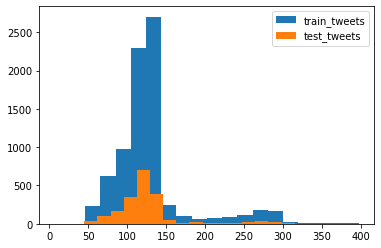

In [33]:
length_train = train['tweet'].str.len()
length_test = test['tweet'].str.len()

plt.hist(length_train, bins=20, label="train_tweets")
plt.hist(length_test, bins=20, label="test_tweets")
plt.legend()
plt.show()

The tweet-length distribution is more or less the same in both train and test data.


### Data Cleaning

In [34]:
combi = train.append(test, ignore_index=True)
combi.shape

(9873, 3)

Given below is a user-defined function to remove unwanted text patterns from the tweets.

In [35]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt    

__1. Removing Twitter Handles (@user)__

In [36]:
combi['tidy_tweet'] = np.vectorize(remove_pattern)(combi['tweet'], "@[\w]*") 
combi.head()

,id,label,tweet,tidy_tweet
0,1,0.0,#fingerprint #Pregnancy Test https://goo.gl/h1MfQV #android #apps #beautiful #cute #health #igers #iphoneonly #iphonesia #iphone,#fingerprint #Pregnancy Test https://goo.gl/h1MfQV #android #apps #beautiful #cute #health #igers #iphoneonly #iphonesia #iphone
1,2,0.0,Finally a transparant silicon case ^^ Thanks to my uncle :) #yay #Sony #Xperia #S #sonyexperias… http://instagram.com/p/YGEt5JC6JM/,Finally a transparant silicon case ^^ Thanks to my uncle :) #yay #Sony #Xperia #S #sonyexperias… http://instagram.com/p/YGEt5JC6JM/
2,3,0.0,We love this! Would you go? #talk #makememories #unplug #relax #iphone #smartphone #wifi #connect... http://fb.me/6N3LsUpCu,We love this! Would you go? #talk #makememories #unplug #relax #iphone #smartphone #wifi #connect... http://fb.me/6N3LsUpCu
3,4,0.0,I'm wired I know I'm George I was made that way ;) #iphone #cute #daventry #home http://instagr.am/p/Li_5_ujS4k/,I'm wired I know I'm George I was made that way ;) #iphone #cute #daventry #home http://instagr.am/p/Li_5_ujS4k/
4,5,1.0,What amazing service! Apple won't even talk to me about a question I have unless I pay them $19.95 for their stupid support!,What amazing service! Apple won't even talk to me about a question I have unless I pay them $19.95 for their stupid support!


__2. Removing Punctuations, Numbers, and Special Characters__

In [37]:
combi['tidy_tweet'] = combi['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")
combi.head(10)

,id,label,tweet,tidy_tweet
0,1,0.0,#fingerprint #Pregnancy Test https://goo.gl/h1MfQV #android #apps #beautiful #cute #health #igers #iphoneonly #iphonesia #iphone,#fingerprint #Pregnancy Test https goo gl h MfQV #android #apps #beautiful #cute #health #igers #iphoneonly #iphonesia #iphone
1,2,0.0,Finally a transparant silicon case ^^ Thanks to my uncle :) #yay #Sony #Xperia #S #sonyexperias… http://instagram.com/p/YGEt5JC6JM/,Finally a transparant silicon case Thanks to my uncle #yay #Sony #Xperia #S #sonyexperias http instagram com p YGEt JC JM
2,3,0.0,We love this! Would you go? #talk #makememories #unplug #relax #iphone #smartphone #wifi #connect... http://fb.me/6N3LsUpCu,We love this Would you go #talk #makememories #unplug #relax #iphone #smartphone #wifi #connect http fb me N LsUpCu
3,4,0.0,I'm wired I know I'm George I was made that way ;) #iphone #cute #daventry #home http://instagr.am/p/Li_5_ujS4k/,I m wired I know I m George I was made that way #iphone #cute #daventry #home http instagr am p Li ujS k
4,5,1.0,What amazing service! Apple won't even talk to me about a question I have unless I pay them $19.95 for their stupid support!,What amazing service Apple won t even talk to me about a question I have unless I pay them for their stupid support
5,6,1.0,iPhone software update fucked up my phone big time Stupid iPhones,iPhone software update fucked up my phone big time Stupid iPhones
6,7,0.0,Happy for us .. #instapic #instadaily #us #sony #xperia #xperiaZ https://instagram.com/p/z9qGfWlvj7/,Happy for us #instapic #instadaily #us #sony #xperia #xperiaZ https instagram com p z qGfWlvj
7,8,0.0,New Type C charger cable #UK http://www.ebay.co.uk/itm/-/112598674021 … #bay #Amazon #etsy New Year #Rob Cross #Toby Young #EVEMUN #McMafia #Taylor #SPECTRE 2018 #NewYear #Starting 2018 #recipes #...,New Type C charger cable #UK http www ebay co uk itm #bay #Amazon #etsy New Year #Rob Cross #Toby Young #EVEMUN #McMafia #Taylor #SPECTRE #NewYear #Starting #recipes #...
8,9,0.0,Bout to go shopping again listening to music #iphone #justme #music #likeforlike #followforfollow… http://instagr.am/p/Vj6bg5tLql/,Bout to go shopping again listening to music #iphone #justme #music #likeforlike #followforfollow http instagr am p Vj bg tLql
9,10,0.0,Photo: #fun #selfie #pool #water #sony #camera #picoftheday #sun #instagood #boy #cute #outdoor... http://tmblr.co/ZAjC0n1ms_Gp8,Photo #fun #selfie #pool #water #sony #camera #picoftheday #sun #instagood #boy #cute #outdoor http tmblr co ZAjC n ms Gp


__3. Removing Short Words__

In [38]:
combi['tidy_tweet'] = combi['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

Let’s take another look at the first few rows of the combined dataframe.

In [39]:
combi.head()

,id,label,tweet,tidy_tweet
0,1,0.0,#fingerprint #Pregnancy Test https://goo.gl/h1MfQV #android #apps #beautiful #cute #health #igers #iphoneonly #iphonesia #iphone,#fingerprint #Pregnancy Test https MfQV #android #apps #beautiful #cute #health #igers #iphoneonly #iphonesia #iphone
1,2,0.0,Finally a transparant silicon case ^^ Thanks to my uncle :) #yay #Sony #Xperia #S #sonyexperias… http://instagram.com/p/YGEt5JC6JM/,Finally transparant silicon case Thanks uncle #yay #Sony #Xperia #sonyexperias http instagram YGEt
2,3,0.0,We love this! Would you go? #talk #makememories #unplug #relax #iphone #smartphone #wifi #connect... http://fb.me/6N3LsUpCu,love this Would #talk #makememories #unplug #relax #iphone #smartphone #wifi #connect http LsUpCu
3,4,0.0,I'm wired I know I'm George I was made that way ;) #iphone #cute #daventry #home http://instagr.am/p/Li_5_ujS4k/,wired know George made that #iphone #cute #daventry #home http instagr
4,5,1.0,What amazing service! Apple won't even talk to me about a question I have unless I pay them $19.95 for their stupid support!,What amazing service Apple even talk about question have unless them their stupid support


__4. Text Normalization__

Here we will use nltk's PorterStemmer() function to normalize the tweets. But before that we will have to tokenize the tweets. Tokens are individual terms or words, and tokenization is the process of splitting a string of text into tokens.

In [40]:
tokenized_tweet = combi['tidy_tweet'].apply(lambda x: x.split()) # tokenizing

In [41]:
tokenized_tweet.head()

0    [#fingerprint, #Pregnancy, Test, https, MfQV, #android, #apps, #beautiful, #cute, #health, #igers, #iphoneonly, #iphonesia, #iphone]
1                        [Finally, transparant, silicon, case, Thanks, uncle, #yay, #Sony, #Xperia, #sonyexperias, http, instagram, YGEt]
2                         [love, this, Would, #talk, #makememories, #unplug, #relax, #iphone, #smartphone, #wifi, #connect, http, LsUpCu]
3                                                      [wired, know, George, made, that, #iphone, #cute, #daventry, #home, http, instagr]
4                                [What, amazing, service, Apple, even, talk, about, question, have, unless, them, their, stupid, support]
Name: tidy_tweet, dtype: object

Now we can normalize the tokenized tweets.

In [42]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming

Now let’s stitch these tokens back together.

In [43]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
    
combi['tidy_tweet'] = tokenized_tweet

<br>
## Story Generation and Visualization from Tweets

__A) Understanding the common words used in the tweets: WordCloud__

Now I want to see how well the given sentiments are distributed across the train dataset. One way to accomplish this task is by understanding the common words by plotting wordclouds.

A wordcloud is a visualization wherein the most frequent words appear in large size and the less frequent words appear in smaller sizes.

Let’s visualize all the words our data using the wordcloud plot.

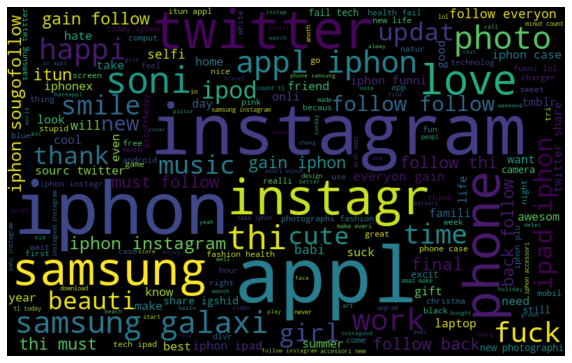

In [44]:
all_words = ' '.join([text for text in combi['tidy_tweet']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

We can see most of the words are positive or neutral. Words like love, great, friend, life are the most frequent ones. It doesn’t give us any idea about the words associated with the racist/sexist tweets. Hence, we will plot separate wordclouds for both the classes (racist/sexist or not) in our train data.

__B) Words in non racist/sexist tweets__

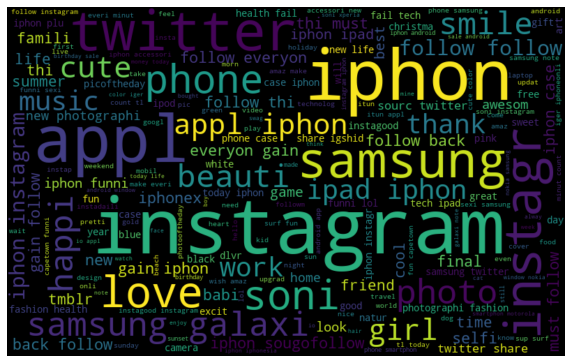

In [45]:
normal_words =' '.join([text for text in combi['tidy_tweet'][combi['label'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Most of the frequent words are compatible with the sentiment, i.e, non-racist/sexists tweets. Similarly, we will plot the word cloud for the other sentiment. Expect to see negative, racist, and sexist terms.

__C) Racist/Sexist Tweets__

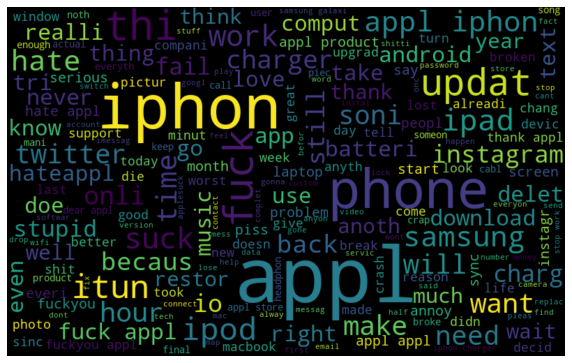

In [46]:
negative_words = ' '.join([text for text in combi['tidy_tweet'][combi['label'] == 1]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

As we can clearly see, most of the words have negative connotations. So, it seems we have a pretty good text data to work on. Next we will the hashtags/trends in our twitter data.

__D) Understanding the impact of Hashtags on tweets sentiment__

In [47]:
# function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [48]:
# extracting hashtags from non racist/sexist tweets

HT_regular = hashtag_extract(combi['tidy_tweet'][combi['label'] == 0])

# extracting hashtags from racist/sexist tweets
HT_negative = hashtag_extract(combi['tidy_tweet'][combi['label'] == 1])

# unnesting list
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])

Now that we have prepared our lists of hashtags for both the sentiments, we can plot the top 'n' hashtags. So, first let’s check the hashtags in the non-racist/sexist tweets.

__Non-Racist/Sexist Tweets__

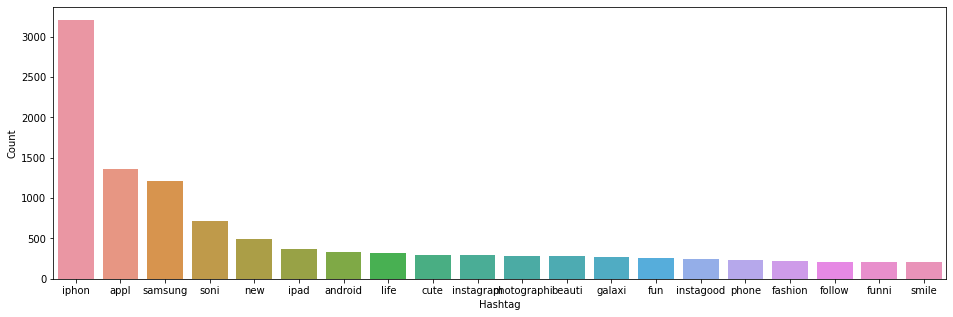

In [49]:
a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

All these hashtags are positive and it makes sense. I am expecting negative terms in the plot of the second list. Let’s check the most frequent hashtags appearing in the racist/sexist tweets.

__Racist/Sexist Tweets__

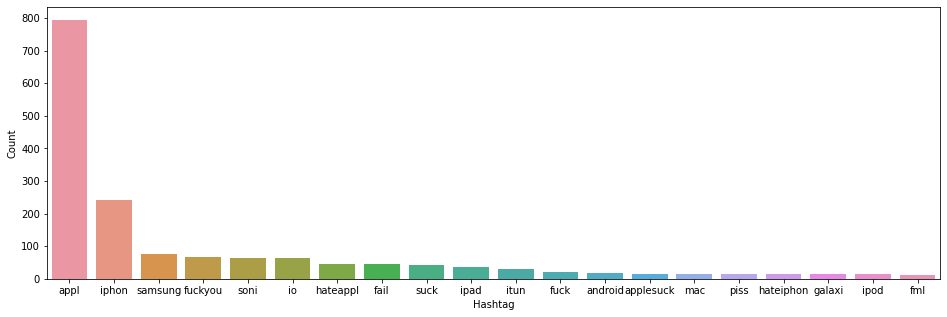

In [50]:
b = nltk.FreqDist(HT_negative)
e = pd.DataFrame({'Hashtag': list(b.keys()), 'Count': list(b.values())})

# selecting top 20 most frequent hashtags
e = e.nlargest(columns="Count", n = 20)   
plt.figure(figsize=(16,5))
ax = sns.barplot(data=e, x= "Hashtag", y = "Count")

As expected, most of the terms are negative with a few neutral terms as well. So, it’s not a bad idea to keep these hashtags in our data as they contain useful information. Next, we will try to extract features from the tokenized tweets.

## Extracting Features from Cleaned Tweets

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import gensim

### Bag-of-Words Features

In [52]:
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
bow = bow_vectorizer.fit_transform(combi['tidy_tweet'])
bow.shape

(9873, 1000)

### TF-IDF Features

In [53]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(combi['tidy_tweet'])
tfidf.shape

(9873, 1000)

### Word Embeddings

#### 1. Word2Vec Embeddings


In [54]:
tokenized_tweet = combi['tidy_tweet'].apply(lambda x: x.split()) # tokenizing

model_w2v = gensim.models.Word2Vec(
            tokenized_tweet,
            size=200, # desired no. of features/independent variables 
            window=5, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 2, # no.of cores
            seed = 34)

model_w2v.train(tokenized_tweet, total_examples= len(combi['tidy_tweet']), epochs=20)

(1837696, 2567180)

Let's play a bit with our Word2Vec model and see how does it perform. We will specify a word and the model will pull out the most similar words from the corpus.

In [55]:
model_w2v.wv.most_similar(positive="dinner")

[('#filchi', 0.7529428005218506),
 ('tess', 0.718031644821167),
 ('achi', 0.7151474952697754),
 ('nephew', 0.7149080038070679),
 ('#kinder', 0.7131513953208923),
 ('#chines', 0.709865391254425),
 ('#philippin', 0.7095435261726379),
 ('aurelio', 0.703701376914978),
 ('ofcours', 0.7016704082489014),
 ('#dinner', 0.6958513259887695)]

In [56]:
model_w2v.wv.most_similar(positive="trump")

[('donald', 0.9478638172149658),
 ('hillari', 0.933390736579895),
 ('lypm', 0.9333192110061646),
 ('clinton', 0.9308214783668518),
 ('jenner', 0.9195520877838135),
 ('amber', 0.9012499451637268),
 ('kyli', 0.8983598351478577),
 ('lyqf', 0.8955940008163452),
 ('hamilton', 0.8948029279708862),
 ('depp', 0.8826503157615662)]

In [57]:
model_w2v['food']

array([ 8.67662858e-03,  1.12331353e-01, -4.47292998e-02, -9.97577235e-02,
       -3.60361069e-01, -3.70311551e-02,  6.06958449e-01, -1.92790985e-01,
        9.59429666e-02, -6.76950142e-02, -1.83220789e-01, -9.13741440e-02,
       -2.26282910e-01, -4.25387681e-01, -3.63983572e-01,  1.97034657e-01,
        6.02686070e-02,  3.00212920e-01,  4.66944128e-01, -1.14221312e-01,
        6.10158071e-02,  1.29603952e-01, -2.75096565e-01,  4.92384937e-03,
       -3.87882628e-02,  2.31958479e-02, -4.24507380e-01,  1.41328052e-01,
        2.33034804e-01,  4.90139760e-02,  5.13757110e-01,  3.32434356e-01,
       -2.60400087e-01,  3.68479267e-02,  4.83861640e-02, -7.90049136e-02,
       -8.14214572e-02,  6.06263131e-02,  3.36208224e-01, -4.90184635e-01,
        5.89880228e-01, -1.63360238e-01, -2.11604342e-01,  4.64527667e-01,
       -3.60651046e-01, -1.43082058e-02, -1.79009344e-02, -6.91213235e-02,
        3.01343918e-01, -2.65142560e-01, -8.24877471e-02,  4.68529388e-02,
       -3.01366031e-01, -

In [58]:
len(model_w2v['food']) #The length of the vector is 200

200

__Preparing Vectors for Tweets__

We will use the below function to create a vector for each tweet by taking the average of the vectors of the words present in the tweet.

In [59]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model_w2v[word].reshape((1, size))
            count += 1.
        except KeyError: # handling the case where the token is not in vocabulary
                         
            continue
    if count != 0:
        vec /= count
    return vec

Preparing word2vec feature set...

In [60]:
wordvec_arrays = np.zeros((len(tokenized_tweet), 200))

for i in range(len(tokenized_tweet)):
    wordvec_arrays[i,:] = word_vector(tokenized_tweet[i], 200)
    
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape    

(9873, 200)

Now we have 200 new features, whereas in Bag of Words and TF-IDF we had 1000 features. 

#### 2. Doc2Vec Embedding

<br>
Let's load the required libraries.

In [61]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models.doc2vec import LabeledSentence

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


To implement doc2vec, we have to __labelise__ or __tag__ each tokenised tweet with unique IDs. We can do so by using Gensim’s *LabeledSentence()* function.

In [62]:
def add_label(twt):
    output = []
    for i, s in zip(twt.index, twt):
        output.append(LabeledSentence(s, ["tweet_" + str(i)]))
    return output

In [63]:
labeled_tweets = add_label(tokenized_tweet) # label all the tweets

Let's have a look at the result.

In [64]:
labeled_tweets[:6]

[LabeledSentence(words=['#fingerprint', '#pregnanc', 'test', 'http', 'mfqv', '#android', '#app', '#beauti', '#cute', '#health', '#iger', '#iphoneonli', '#iphonesia', '#iphon'], tags=['tweet_0']),
 LabeledSentence(words=['final', 'transpar', 'silicon', 'case', 'thank', 'uncl', '#yay', '#soni', '#xperia', '#sonyexperia', 'http', 'instagram', 'yget'], tags=['tweet_1']),
 LabeledSentence(words=['love', 'thi', 'would', '#talk', '#makememori', '#unplug', '#relax', '#iphon', '#smartphon', '#wifi', '#connect', 'http', 'lsupcu'], tags=['tweet_2']),
 LabeledSentence(words=['wire', 'know', 'georg', 'made', 'that', '#iphon', '#cute', '#daventri', '#home', 'http', 'instagr'], tags=['tweet_3']),
 LabeledSentence(words=['what', 'amaz', 'servic', 'appl', 'even', 'talk', 'about', 'question', 'have', 'unless', 'them', 'their', 'stupid', 'support'], tags=['tweet_4']),
 LabeledSentence(words=['iphon', 'softwar', 'updat', 'fuck', 'phone', 'time', 'stupid', 'iphon'], tags=['tweet_5'])]

<br>
Now let's train a __doc2vec__ model. 

In [65]:
model_d2v = gensim.models.Doc2Vec(dm=1, # dm = 1 for ‘distributed memory’ model 
                                  dm_mean=1, # dm = 1 for using mean of the context word vectors
                                  size=200, # no. of desired features
                                  window=5, # width of the context window
                                  negative=7, # if > 0 then negative sampling will be used
                                  min_count=5, # Ignores all words with total frequency lower than 2.
                                  workers=3, # no. of cores
                                  alpha=0.1, # learning rate
                                  seed = 23)

model_d2v.build_vocab([i for i in tqdm(labeled_tweets)])

/usr/local/lib/python3.7/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
100%|██████████| 9873/9873 [00:00<00:00, 1441463.50it/s]


In [66]:
model_d2v.train(labeled_tweets, total_examples= len(combi['tidy_tweet']), epochs=15)

__Preparing doc2vec Feature Set__

In [67]:
docvec_arrays = np.zeros((len(tokenized_tweet), 200))

for i in range(len(combi)):
    docvec_arrays[i,:] = model_d2v.docvecs[i].reshape((1,200))
    
docvec_df = pd.DataFrame(docvec_arrays)
docvec_df.shape

(9873, 200)

---

## Model Building

We are now done with all the pre-modeling stages required to get the data in the proper form and shape. We will be building models on the datasets with different feature sets prepared in the earlier sections — Bag-of-Words, TF-IDF, word2vec vectors, and doc2vec vectors. We will use the following algorithms to build models:

1. Logistic Regression
2. Support Vector Machine
3. RandomForest
4. XGBoost

### 1. Logistic Regression

In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

#### Bag-of-Words Features

In [83]:
print((bow))

  (0, 860)	1
  (0, 388)	1
  (0, 20)	1
  (0, 29)	1
  (0, 61)	1
  (0, 187)	1
  (0, 371)	1
  (0, 397)	1
  (0, 434)	1
  (0, 436)	1
  (0, 431)	1
  (1, 388)	1
  (1, 279)	1
  (1, 127)	1
  (1, 863)	1
  (1, 986)	1
  (1, 781)	1
  (1, 984)	1
  (1, 419)	1
  (2, 388)	1
  (2, 431)	1
  (2, 501)	1
  (2, 866)	1
  (2, 851)	1
  (2, 691)	1
  :	:
  (9869, 118)	1
  (9869, 998)	1
  (9869, 48)	1
  (9869, 521)	1
  (9870, 431)	1
  (9870, 31)	1
  (9870, 724)	2
  (9870, 338)	1
  (9870, 6)	1
  (9870, 704)	1
  (9870, 351)	1
  (9870, 664)	1
  (9870, 178)	1
  (9871, 31)	1
  (9871, 873)	1
  (9871, 715)	1
  (9872, 388)	1
  (9872, 279)	1
  (9872, 418)	1
  (9872, 614)	1
  (9872, 318)	1
  (9872, 717)	1
  (9872, 564)	1
  (9872, 330)	1
  (9872, 271)	2


In [84]:
train_bow = bow[:7920,:]
test_bow = bow[7920:,:]

# splitting data into training and validation set
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, train['label'],  
                                                          random_state=42, 
                                                          test_size=0.3)

In [85]:
lreg = LogisticRegression()
lreg.fit(xtrain_bow, ytrain) # training the model

prediction = lreg.predict_proba(xvalid_bow) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 than 1 else 0
prediction_int = prediction_int.astype(np.int)

f1_score(yvalid, prediction_int) # calculating f1 score

0.8055749128919861

Now let's make predictions for the test dataset and create a submission file.

In [86]:
test_pred = lreg.predict_proba(test_bow)
test_pred_int = test_pred[:,1] >= 0.3
test_pred_int = test_pred_int.astype(np.int)
test['label'] = test_pred_int
submission = test[['id','label']]
submission.to_csv('sub_lreg_bow.csv', index=False) # writing data to a CSV file

Public Leaderboard F1 Score: 0.8756

#### TF-IDF Features

In [87]:
train_tfidf = tfidf[:7920,:]
test_tfidf = tfidf[7920:,:]

xtrain_tfidf = train_tfidf[ytrain.index]
xvalid_tfidf = train_tfidf[yvalid.index]

In [88]:
lreg.fit(xtrain_tfidf, ytrain)

prediction = lreg.predict_proba(xvalid_tfidf)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)

f1_score(yvalid, prediction_int)

0.817234190410007

Public Leaderboard F1 Score: 0.564

#### Word2Vec Features

In [89]:
train_w2v = wordvec_df.iloc[:7920,:]
test_w2v = wordvec_df.iloc[7920:,:]

xtrain_w2v = train_w2v.iloc[ytrain.index,:]
xvalid_w2v = train_w2v.iloc[yvalid.index,:]

In [90]:
lreg.fit(xtrain_w2v, ytrain)

prediction = lreg.predict_proba(xvalid_w2v)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
f1_score(yvalid, prediction_int)

0.8214037526059763

Public Leaderboard F1 Score: 0.8754

#### Doc2Vec Features

In [ ]:
train_d2v = docvec_df.iloc[:31962,:]
test_d2v = docvec_df.iloc[31962:,:]

xtrain_d2v = train_d2v.iloc[ytrain.index,:]
xvalid_d2v = train_d2v.iloc[yvalid.index,:]

In [ ]:
lreg.fit(xtrain_d2v, ytrain)

prediction = lreg.predict_proba(xvalid_d2v)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
f1_score(yvalid, prediction_int)

0.36731107205623909

Public Leaderboard F1 Score: 0.381

### 2. Support Vector Machine

In [ ]:
from sklearn import svm

#### Bag-of-Words Features

In [ ]:
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_bow, ytrain)

prediction = svc.predict_proba(xvalid_bow)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
f1_score(yvalid, prediction_int)

0.50837988826815639

Again let's make predictions for the test dataset and create another submission file.

In [ ]:
test_pred = svc.predict_proba(test_bow)
test_pred_int = test_pred[:,1] >= 0.3
test_pred_int = test_pred_int.astype(np.int)
test['label'] = test_pred_int
submission = test[['id','label']]
submission.to_csv('sub_svc_bow.csv', index=False)

Public Leaderboard F1 Score: 0.554

Here both validation score and leaderboard score are slightly lesser than the Logistic Regression scores for bag-of-words features. 

#### TF-IDF Features

In [ ]:
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_tfidf, ytrain)

prediction = svc.predict_proba(xvalid_tfidf)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
f1_score(yvalid, prediction_int)

0.51048313582497717

Public Leaderboard F1 Score: 0.546

#### Word2Vec Features

In [ ]:
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_w2v, ytrain)

prediction = svc.predict_proba(xvalid_w2v)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
f1_score(yvalid, prediction_int)

0.61381475667189955

Public Leaderboard F1 Score: 0.654

#### Doc2Vec Features

In [ ]:
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_d2v, ytrain)

prediction = svc.predict_proba(xvalid_d2v)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
f1_score(yvalid, prediction_int)

0.20273348519362189

Public Leaderboard F1 Score: 0.214

### 3. RandomForest

In [91]:
from sklearn.ensemble import RandomForestClassifier

#### Bag-of-Words Features

In [92]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_bow, ytrain)

prediction = rf.predict(xvalid_bow)
f1_score(yvalid, prediction)

0.7712724434035909

Let's make predictions for the test dataset and create another submission file.

In [93]:
test_pred = rf.predict(test_bow)
test['label'] = test_pred
submission = test[['id','label']]
submission.to_csv('sub_rf_bow.csv', index=False)

Public Leaderboard F1 Score: 0.86

#### TF-IDF Features

In [101]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_tfidf, ytrain)

prediction = rf.predict(xvalid_tfidf)
f1_score(yvalid, prediction)

0.795088257866462

In [102]:
test_pred = rf.predict(test_tfidf)
test['label'] = test_pred
submission = test[['id','label']]
submission.to_csv('sub_rf_TfIdf.csv', index=False)

Public Leaderboard F1 Score: 0.87371

#### Word2Vec Features

In [103]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_w2v, ytrain)

prediction = rf.predict(xvalid_w2v)
f1_score(yvalid, prediction)

0.8108108108108107

In [104]:
test_pred = rf.predict(test_w2v)
test['label'] = test_pred
submission = test[['id','label']]
submission.to_csv('sub_rf_W2V.csv', index=False)

Public Leaderboard F1 Score: 0.549

#### Doc2Vec Features

In [99]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_d2v, ytrain)

prediction = rf.predict(xvalid_d2v)
f1_score(yvalid, prediction)

NameError: ignored

Public Leaderboard F1 Score: 0.07

### 4. XGBoost

In [ ]:
from xgboost import XGBClassifier

#### Bag-of-Words Features

In [ ]:
xgb_model = XGBClassifier(max_depth=6, n_estimators=1000).fit(xtrain_bow, ytrain)
prediction = xgb_model.predict(xvalid_bow)
f1_score(yvalid, prediction)

0.51306873184898372

In [ ]:
test_pred = xgb_model.predict(test_bow)
test['label'] = test_pred
submission = test[['id','label']]
submission.to_csv('sub_xgb_bow.csv', index=False)

Public Leaderboard F1 Score: 0.554

#### TF-IDF Features

In [ ]:
xgb = XGBClassifier(max_depth=6, n_estimators=1000).fit(xtrain_tfidf, ytrain)

prediction = xgb.predict(xvalid_tfidf)
f1_score(yvalid, prediction)

0.51858913250714966

Public Leaderboard F1 Score: 0.554

#### Word2Vec Features

In [96]:
xgb = XGBClassifier(max_depth=6, n_estimators=1000, nthread= 3).fit(xtrain_w2v, ytrain)

NameError: ignored

In [97]:
prediction = xgb.predict(xvalid_w2v)
f1_score(yvalid, prediction)

NameError: ignored

Public Leaderboard F1 Score: 0.698

XGBoost model on word2vec features has outperformed all the previuos models in this course.

#### Doc2Vec Features

In [ ]:
xgb = XGBClassifier(max_depth=6, n_estimators=1000, nthread= 3).fit(xtrain_d2v, ytrain)

In [ ]:
prediction = xgb.predict(xvalid_d2v)
f1_score(yvalid, prediction)

0.34490481522956323

Public Leaderboard F1 Score: 0.374

<br>
## Model Finetuning

In [ ]:
import xgboost as xgb

Here we will use DMatrices. A DMatrix can contain both the features and the target.

In [ ]:
dtrain = xgb.DMatrix(xtrain_w2v, label=ytrain)
dvalid = xgb.DMatrix(xvalid_w2v, label=yvalid)
dtest = xgb.DMatrix(test_w2v)

In [ ]:
# Parameters that we are going to tune
params = {
    'objective':'binary:logistic',
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1
}

We will prepare a custom evaluation metric to calculate F1 score.

In [ ]:
def custom_eval(preds, dtrain):
    labels = dtrain.get_label().astype(np.int)
    preds = (preds >= 0.3).astype(np.int)
    return [('f1_score', f1_score(labels, preds))]

__General Approach for Parameter Tuning__

We will follow the steps below to tune the parameters.

1. Choose a relatively high learning rate. Usually a learning rate of 0.3 is used at this stage.
2. Tune tree-specific parameters such as max_depth, min_child_weight, subsample, colsample_bytree keeping the learning rate fixed.
3. Tune the learning rate.
4. Finally tune gamma to avoid overfitting.

*Tuning max_depth* and *min_child_weight*

In [ ]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(6,10) 
    for min_child_weight in range(5,8)
]

In [ ]:
max_f1 = 0. # initializing with 0
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))

    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight

    # Cross-validation
    cv_results = xgb.cv(
        params,
        dtrain,
        feval= custom_eval,
        num_boost_round=200,
        maximize=True,
        seed=16,
        nfold=5,
        early_stopping_rounds=10
    )

    # Finding best F1 Score
    mean_f1 = cv_results['test-f1_score-mean'].max()
    boost_rounds = cv_results['test-f1_score-mean'].argmax()
    print("\tF1 Score {} for {} rounds".format(mean_f1, boost_rounds))
    if mean_f1 > max_f1:
        max_f1 = mean_f1
        best_params = (max_depth,min_child_weight)

print("Best params: {}, {}, F1 Score: {}".format(best_params[0], best_params[1], max_f1))


CV with max_depth=6, min_child_weight=5


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.


	F1 Score 0.6751088000000001 for 64 rounds
CV with max_depth=6, min_child_weight=6
	F1 Score 0.6703884 for 55 rounds
CV with max_depth=6, min_child_weight=7
	F1 Score 0.6761038 for 57 rounds
CV with max_depth=7, min_child_weight=5
	F1 Score 0.6784994 for 51 rounds
CV with max_depth=7, min_child_weight=6
	F1 Score 0.6808281999999999 for 47 rounds
CV with max_depth=7, min_child_weight=7
	F1 Score 0.6781346000000001 for 115 rounds
CV with max_depth=8, min_child_weight=5
	F1 Score 0.6634426 for 36 rounds
CV with max_depth=8, min_child_weight=6
	F1 Score 0.6822174000000001 for 71 rounds
CV with max_depth=8, min_child_weight=7
	F1 Score 0.6618758 for 32 rounds
CV with max_depth=9, min_child_weight=5
	F1 Score 0.6580265999999999 for 32 rounds
CV with max_depth=9, min_child_weight=6
	F1 Score 0.673238 for 43 rounds
CV with max_depth=9, min_child_weight=7
	F1 Score 0.6738529999999999 for 54 rounds
Best params: 8, 6, F1 Score: 0.6822174000000001


Updating __max_depth__ and __min_child_weight__ parameters.

In [ ]:
params['max_depth'] = 8
params['min_child_weight'] = 6

Tuning subsample and colsample.

In [ ]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(5,10)]
    for colsample in [i/10. for i in range(5,10)]
]

In [ ]:
max_f1 = 0.
best_params = None
for subsample, colsample in gridsearch_params:
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))

    # Update our parameters
    params['colsample'] = colsample
    params['subsample'] = subsample

    cv_results = xgb.cv(
        params,
        dtrain,
        feval= custom_eval,
        num_boost_round=200,
        maximize=True,
        seed=16,
        nfold=5,
        early_stopping_rounds=10
    )

    # Finding best F1 Score
    mean_f1 = cv_results['test-f1_score-mean'].max()
    boost_rounds = cv_results['test-f1_score-mean'].argmax()
    print("\tF1 Score {} for {} rounds".format(mean_f1, boost_rounds))
    if mean_f1 > max_f1:
        max_f1 = mean_f1
        best_params = (subsample, colsample)

print("Best params: {}, {}, F1 Score: {}".format(best_params[0], best_params[1], max_f1))

CV with subsample=0.5, colsample=0.5


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.


	F1 Score 0.6651868000000001 for 78 rounds
CV with subsample=0.5, colsample=0.6
	F1 Score 0.6651868000000001 for 78 rounds
CV with subsample=0.5, colsample=0.7
	F1 Score 0.6651868000000001 for 78 rounds
CV with subsample=0.5, colsample=0.8
	F1 Score 0.6651868000000001 for 78 rounds
CV with subsample=0.5, colsample=0.9
	F1 Score 0.6651868000000001 for 78 rounds
CV with subsample=0.6, colsample=0.5
	F1 Score 0.6776694000000001 for 70 rounds
CV with subsample=0.6, colsample=0.6
	F1 Score 0.6776694000000001 for 70 rounds
CV with subsample=0.6, colsample=0.7
	F1 Score 0.6776694000000001 for 70 rounds
CV with subsample=0.6, colsample=0.8
	F1 Score 0.6776694000000001 for 70 rounds
CV with subsample=0.6, colsample=0.9
	F1 Score 0.6776694000000001 for 70 rounds
CV with subsample=0.7, colsample=0.5
	F1 Score 0.673453 for 58 rounds
CV with subsample=0.7, colsample=0.6
	F1 Score 0.673453 for 58 rounds
CV with subsample=0.7, colsample=0.7
	F1 Score 0.673453 for 58 rounds
CV with subsample=0.7, cols

Updating __subsample__ and __colsample_bytree__.

In [ ]:
params['subsample'] = .9
params['colsample_bytree'] = .5

Now let's tune the learning rate.

In [ ]:
max_f1 = 0.
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))

    # Update ETA
    params['eta'] = eta

    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        feval= custom_eval,
        num_boost_round=1000,
        maximize=True,
        seed=16,
        nfold=5,
        early_stopping_rounds=20
    )

    # Finding best F1 Score
    mean_f1 = cv_results['test-f1_score-mean'].max()
    boost_rounds = cv_results['test-f1_score-mean'].argmax()
    print("\tF1 Score {} for {} rounds".format(mean_f1, boost_rounds))
    if mean_f1 > max_f1:
        max_f1 = mean_f1
        best_params = eta

print("Best params: {}, F1 Score: {}".format(best_params, max_f1))

CV with eta=0.3


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.


	F1 Score 0.6849056000000001 for 84 rounds
CV with eta=0.2
	F1 Score 0.684616 for 93 rounds
CV with eta=0.1
	F1 Score 0.6864700000000001 for 211 rounds
CV with eta=0.05
	F1 Score 0.6846697999999999 for 200 rounds
CV with eta=0.01
	F1 Score 0.1302024 for 0 rounds
CV with eta=0.005
	F1 Score 0.1302024 for 0 rounds
Best params: 0.1, F1 Score: 0.6864700000000001


In [ ]:
params['eta'] = .1

Now lets tune __gamma__ value using the parameters already tuned above. We’ll check for 5 values here.

In [ ]:
max_f1 = 0.
best_params = None
for gamma in range(0,15):
    print("CV with gamma={}".format(gamma/10.))

    # Update ETA
    params['gamma'] = gamma/10.

    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        feval= custom_eval,
        num_boost_round=200,
        maximize=True,
        seed=16,
        nfold=5,
        early_stopping_rounds=10
    )

    # Finding best F1 Score
    mean_f1 = cv_results['test-f1_score-mean'].max()
    boost_rounds = cv_results['test-f1_score-mean'].argmax()
    print("\tF1 Score {} for {} rounds".format(mean_f1, boost_rounds))
    if mean_f1 > max_f1:
        max_f1 = mean_f1
        best_params = gamma/10.

print("Best params: {}, F1 Score: {}".format(best_params, max_f1))

CV with gamma=0.0


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.


	F1 Score 0.6516993999999999 for 46 rounds
CV with gamma=0.1
	F1 Score 0.6425626 for 65 rounds
CV with gamma=0.2
	F1 Score 0.6429636 for 64 rounds
CV with gamma=0.3
	F1 Score 0.6433358 for 64 rounds
CV with gamma=0.4
	F1 Score 0.6502844 for 81 rounds
CV with gamma=0.5
	F1 Score 0.6497812 for 69 rounds
CV with gamma=0.6
	F1 Score 0.6416596 for 48 rounds
CV with gamma=0.7
	F1 Score 0.6511064 for 61 rounds
CV with gamma=0.8
	F1 Score 0.648954 for 75 rounds
CV with gamma=0.9
	F1 Score 0.6470513999999999 for 64 rounds
CV with gamma=1.0
	F1 Score 0.6607518 for 110 rounds
CV with gamma=1.1
	F1 Score 0.660221 for 83 rounds
CV with gamma=1.2
	F1 Score 0.6627242 for 117 rounds
CV with gamma=1.3
	F1 Score 0.6492042 for 63 rounds
CV with gamma=1.4
	F1 Score 0.6435412 for 54 rounds
Best params: 1.2, F1 Score: 0.6627242


In [ ]:
params['gamma'] = 1.2

Let's have a look at the final list of parameters.

In [ ]:
params

{'colsample': 0.9,
 'colsample_bytree': 0.5,
 'eta': 0.1,
 'max_depth': 8,
 'min_child_weight': 6,
 'objective': 'binary:logistic',
 'subsample': 0.9}

In [ ]:
xgb_model = xgb.train(
    params,
    dtrain,
    feval= custom_eval,
    num_boost_round= 1000,
    maximize=True,
    evals=[(dvalid, "Validation")],
    early_stopping_rounds=10
)

[0]	Validation-error:0.065909	Validation-f1_score:0.133165
Multiple eval metrics have been passed: 'Validation-f1_score' will be used for early stopping.

Will train until Validation-f1_score hasn't improved in 10 rounds.
[1]	Validation-error:0.058922	Validation-f1_score:0.133165
[2]	Validation-error:0.056523	Validation-f1_score:0.133165
[3]	Validation-error:0.055793	Validation-f1_score:0.133165
[4]	Validation-error:0.054229	Validation-f1_score:0.133165
[5]	Validation-error:0.054437	Validation-f1_score:0.371141
[6]	Validation-error:0.053916	Validation-f1_score:0.45042
[7]	Validation-error:0.053082	Validation-f1_score:0.5158
[8]	Validation-error:0.053082	Validation-f1_score:0.565517
[9]	Validation-error:0.052873	Validation-f1_score:0.577889
[10]	Validation-error:0.052039	Validation-f1_score:0.592938
[11]	Validation-error:0.05183	Validation-f1_score:0.601116
[12]	Validation-error:0.051309	Validation-f1_score:0.603037
[13]	Validation-error:0.052039	Validation-f1_score:0.607988
[14]	Valida

In [ ]:
test_pred = xgb_model.predict(dtest)
test['label'] = (test_pred >= 0.3).astype(np.int)
submission = test[['id','label']]
submission.to_csv('sub_xgb_w2v_06062018.csv', index=False)

Public Leaderboard F1 Score: 0.703